In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('Assignment.csv')

In [3]:
data.head()

,AGEPH,CODPOSS,duree,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc
0,64,1000,1.000000,0.000000,0,0.000000,0.000000,2-5,Female,Petrol,Once,Private,No,No,MTPL+,66-110
1,28,1000,0.046575,-3.066684,1,21.470588,155.974606,6-10,Female,Petrol,Twice,Private,No,No,MTPL,66-110
2,58,1000,0.402740,-0.909465,0,0.000000,0.000000,>10,Female,Petrol,Thrice,Private,No,No,MTPL,<66
3,37,1030,0.169863,-1.772763,0,0.000000,0.000000,2-5,Female,Petrol,Once,Professional,No,No,MTPL+++,66-110
4,29,1030,1.000000,0.000000,0,0.000000,0.000000,6-10,Female,Petrol,Once,Private,No,No,MTPL+,<66


## Feature engineering

In [4]:
data['expo'] =  data['lnexpo'].apply(np.exp)
data['agecar'] =  data['agecar'].map({'0-1': 0, '2-5': 1, '6-10': 2, '>10': 3}) 
data['sexp'] =  data['sexp'].map({'Female': 0, 'Male':1}) 
data['fuelc'] = data['fuelc'].map({'Petrol': 0, 'Gasoil': 1})
data['split'] = data['split'].map({'Once': 0, 'Twice': 1, 'Thrice': 2, 'Monthly': 3})
data['usec'] = data['usec'].map({'Private': 0, 'Professional': 1})
data['fleetc'] = data['fleetc'].map({'No': 0, 'Yes': 1})
data['sportc'] = data['sportc'].map({'No': 0, 'Yes': 1})
data['coverp'] = data['coverp'].map({'MTPL': 0, 'MTPL+': 1, 'MTPL+++': 2})
data['powerc'] = data['powerc'].map({'<66': 0, '66-110': 1, '>110': 2})

In [5]:
# feat_cols = ['expo','agecar','sexp','fuelc','split','usec','fleetc','sportc','coverp', 'powerc', 'AGEPH', 'nbrtotc', 'chargtot']
# data = data[feat_cols]

### Handling postal code

In [7]:
df1 = data[['CODPOSS']]
df2 = geo_data[['CODPOSS', 'LAT', 'LONG']]
mapped_geodata = pd.merge(df1, df2, on='CODPOSS', how='left')

In [8]:
mapped_geodata

,CODPOSS,LAT,LONG
0,1000,50.833333,4.350000
1,1000,50.833333,4.350000
2,1000,50.833333,4.350000
3,1030,50.850000,4.383333
4,1030,50.850000,4.383333
...,...,...,...
163652,9960,51.216667,3.750000
163653,9960,51.216667,3.750000
163654,9960,51.216667,3.750000
163655,9970,51.216667,3.616667


In [9]:
clustering_df = pd.DataFrame({
    'LAT': mapped_geodata['LAT'],
    'LONG': mapped_geodata['LONG'],
    'loss': data['chargtot'] / data['expo']
})

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Normalize the data using z-score normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clustering_df[['LAT', 'LONG', 'loss']])

# Perform K-means clustering with k=3 on the normalized data
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_scaled)

# Add the cluster labels to the DataFrame
clustering_df['cluster'] = kmeans.labels_

# Print the resulting DataFrame
clustering_df

C:\Users\seidm\anaconda3\envs\dsei\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,LAT,LONG,loss,cluster
0,50.833333,4.350000,0.000000,0
1,50.833333,4.350000,3348.866538,0
2,50.833333,4.350000,0.000000,0
3,50.850000,4.383333,0.000000,0
4,50.850000,4.383333,0.000000,0
...,...,...,...,...
163652,51.216667,3.750000,0.000000,0
163653,51.216667,3.750000,0.000000,0
163654,51.216667,3.750000,0.000000,0
163655,51.216667,3.616667,3177.994988,0


In [ ]:
clustering_df['cluster'].value_counts()

In [11]:
data['location_category'] = clustering_df['cluster']

In [12]:
feat_cols = ['agecar','sexp','fuelc','split','usec','fleetc','sportc','coverp', 'powerc', 'AGEPH', 'location_category']
# 'nbrtotc', 'chargtot, ''expo'
X = data[feat_cols]


## Frequency prediction

In [13]:
y_freq = data['nbrtotc'] / data['expo']
w_freq = data['expo']

In [14]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import ggplot, geom_point, geom_line, aes, theme_set, theme_bw
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance, partial_dependence, PartialDependenceDisplay

In [15]:
tree_freq = DecisionTreeRegressor(criterion='poisson', max_depth=2, min_samples_split=10000, min_samples_leaf=5000)
# fit the tree to our target with weights
X_freq = X.copy()
tree_freq.fit(X=X_freq, y=y_freq, sample_weight=w_freq)
# print the tree
tree_freq

DecisionTreeRegressor(criterion='poisson', max_depth=2, min_samples_leaf=5000,
                      min_samples_split=10000)

In [16]:
tree_freq_pred = tree_freq.predict(X_freq)

## Severity

In [64]:
X_sev

,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,AGEPH,location_category
15,2,0,0,1,0,0,0,0,1,28,0
20,2,0,0,3,0,0,1,0,2,52,0
28,2,0,0,3,0,0,0,0,0,45,0
67,1,0,0,3,0,0,0,2,1,33,0
98,3,0,0,2,0,0,0,0,1,31,0
...,...,...,...,...,...,...,...,...,...,...,...
163523,1,1,0,0,0,0,0,2,0,64,0
163530,3,1,0,1,0,0,0,0,0,38,0
163546,2,1,0,0,0,0,0,0,0,38,0
163624,3,1,0,0,0,0,0,0,0,43,0


In [19]:
data_sev = data[data['nbrtotc'] > 1]
X_sev = data_sev[feat_cols]
y_sev = data_sev['chargtot'] / data_sev['nbrtotc']
y_sev_log = np.log(y_sev)
w_sev = data_sev['nbrtotc']

tree_sev = DecisionTreeRegressor(criterion='squared_error', max_depth=1).fit(X_sev, y_sev, w_sev)

In [20]:
# collect the feature names and importance scores
tree_freq = DecisionTreeRegressor(criterion='poisson', max_leaf_nodes=25, min_samples_leaf = 1000).fit(X, y_freq, w_freq)
tree_freq_fi = pd.DataFrame({'feature':tree_freq.feature_names_in_, 'importance':tree_freq.feature_importances_}).sort_values('importance', ascending=False)
# inspect the results
tree_freq_fi

,feature,importance
9,AGEPH,0.600330
3,split,0.267702
2,fuelc,0.043010
0,agecar,0.029620
7,coverp,0.022225
1,sexp,0.020694
10,location_category,0.008611
8,powerc,0.007808
4,usec,0.000000
5,fleetc,0.000000


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

def get_feat_importance(tree_based_alg, X):

    # Get the feature importances
    importances = tree_based_alg.feature_importances_

    # Create a dataframe to store the feature importances
    feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

    # Sort the dataframe by importance
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)


    plt.figure(figsize=(10, 6))

    # Plot the feature importances
    plt.bar(feature_importances['feature'], feature_importances['importance'])
    plt.xticks(rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Feature Importance')
    plt.show()
    
    return pd.DataFrame(
        {
            'feature':tree_based_alg.feature_names_in_, 
            'importance':tree_based_alg.feature_importances_
        }
    ).sort_values('importance', ascending=False)

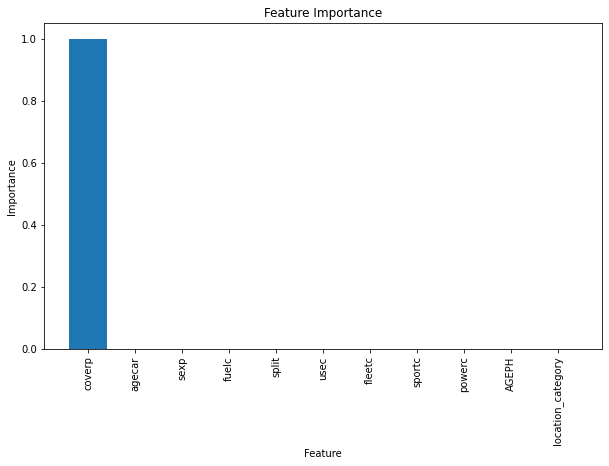

,feature,importance
7,coverp,1.0
0,agecar,0.0
1,sexp,0.0
2,fuelc,0.0
3,split,0.0
4,usec,0.0
5,fleetc,0.0
6,sportc,0.0
8,powerc,0.0
9,AGEPH,0.0


In [22]:
get_feat_importance(tree_sev, X_sev)

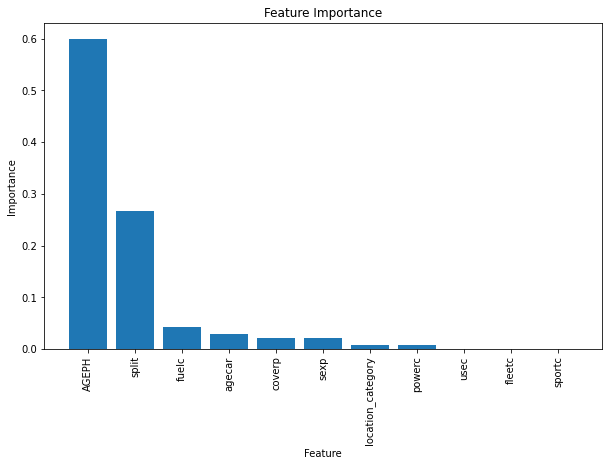

,feature,importance
9,AGEPH,0.600330
3,split,0.267702
2,fuelc,0.043010
0,agecar,0.029620
7,coverp,0.022225
1,sexp,0.020694
10,location_category,0.008611
8,powerc,0.007808
4,usec,0.000000
5,fleetc,0.000000


In [23]:
get_feat_importance(tree_freq, X_freq)

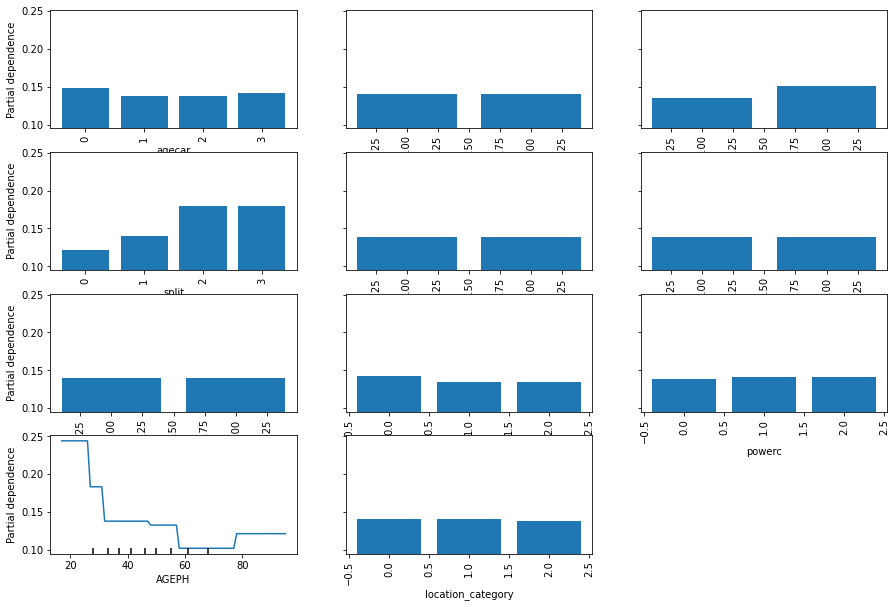

In [24]:
# create pdps for a couple of features
fig, ax = plt.subplots(figsize=(15, 10))
PartialDependenceDisplay.from_estimator(tree_freq, X_freq, features =['agecar', 'sexp', 'fuelc', 'split', 'usec', 'fleetc', 'sportc',
       'coverp', 'powerc', 'AGEPH', 'location_category'], 
                                        categorical_features=['agecar', 'sexp', 'fuelc', 'split', 'usec', 'fleetc', 'sportc',
       'coverp', 'powerc', 'location_category'], 
                                        kind='average', ax=ax);

In [25]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import ggplot, geom_point, geom_line, geom_vline, geom_hline, aes, theme_set, theme_bw
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.utils import shuffle
from sklearn.inspection import permutation_importance, partial_dependence, PartialDependenceDisplay
from sklearn.ensemble import BaggingRegressor, BaggingClassifier, RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

### Xgboost

In [26]:
xgb_freq = xgb.XGBRegressor(n_estimators = 500,
                            objective='count:poisson',
                            monotone_constraints = (1,0,0,0,0,0,0,0,0),
                            max_depth = 3,
                            learning_rate = 0.01,
                            base_score = np.sum(y_freq * w_freq)/np.sum(w_freq))
# fit the xgboost model
xgb_freq.fit(X_freq, y_freq, sample_weight=w_freq)

XGBRegressor(base_score=0.13933551567356267, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan,
             monotone_constraints=(1, 0, 0, 0, 0, 0, 0, 0, 0), n_estimators=500,
             n_jobs=None, num_parallel_tree=None, objective='count:poisson',
             predictor=None, ...)

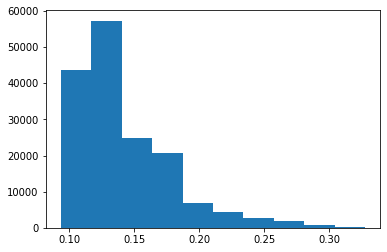

In [27]:
# prediction on the target scale
pred_on_target_scale = np.round(xgb_freq.predict(X_freq), 5)
plt.hist(pred_on_target_scale, bins=10);

In [28]:
# summary statistics of the predictions
pd.Series(pred_on_target_scale).describe()

count    163657.000000
mean          0.141123
std           0.038069
min           0.093440
25%           0.115110
50%           0.131590
75%           0.160830
max           0.327470
dtype: float64

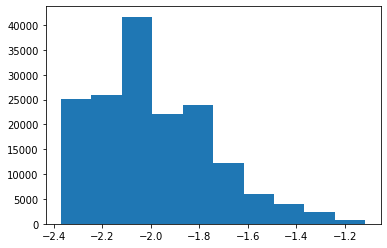

In [29]:
# prediction on raw log scale
pred_on_log_scale = np.round(xgb_freq.predict(X_freq, output_margin = True), 5)
plt.hist(pred_on_log_scale, bins=10);

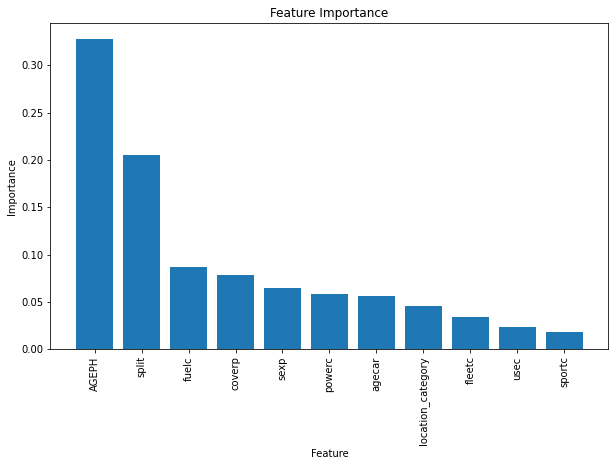

,feature,importance
9,AGEPH,0.328123
3,split,0.205069
2,fuelc,0.086808
7,coverp,0.078686
1,sexp,0.065066
8,powerc,0.058406
0,agecar,0.056507
10,location_category,0.045935
5,fleetc,0.033708
4,usec,0.023807


In [30]:
get_feat_importance(xgb_freq, X_freq)

### XGB severity

In [62]:
y_sev

15         788.177462
20        2961.798782
28         211.279651
67         842.800800
98        1586.121929
             ...     
163523     145.017712
163530    1186.195305
163546     959.670202
163624    2135.255665
163656    6909.114797
Length: 1743, dtype: float64

In [31]:
xgb_sev = xgb.XGBRegressor(n_estimators = 100,
                           objective='reg:gamma',
                           max_depth = 3,
                           learning_rate = 0.01,
                           base_score = np.sum(y_sev * w_sev)/np.sum(w_sev))
# fit the xgboost model
xgb_sev.fit(X_sev, y_sev, sample_weight=w_sev)

XGBRegressor(base_score=1579.5715307212124, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:gamma', predictor=None, ...)

In [32]:
len(X_sev)

1743

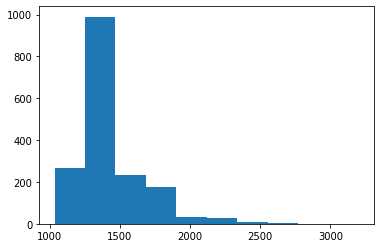

In [33]:
# prediction on the target scale
pred_on_target_scale = np.round(xgb_sev.predict(X_sev), 2)
plt.hist(pred_on_target_scale, bins=10);

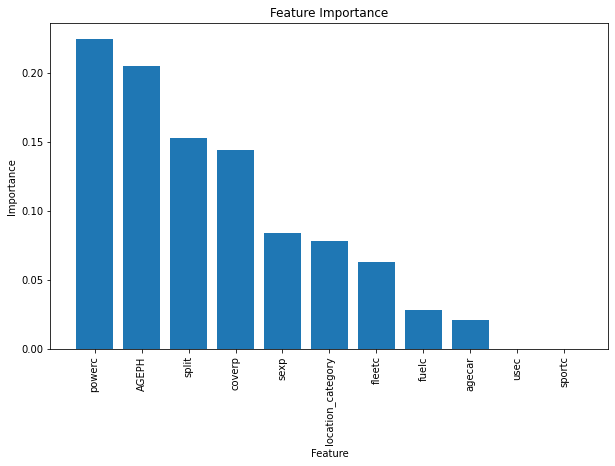

,feature,importance
8,powerc,0.224579
9,AGEPH,0.204630
3,split,0.152669
7,coverp,0.144208
1,sexp,0.083897
10,location_category,0.078187
5,fleetc,0.062682
2,fuelc,0.028125
0,agecar,0.021023
4,usec,0.000000


In [34]:
get_feat_importance(xgb_sev, X_sev)

# Grid search cv frequency


In [35]:
param_dict = {'max_depth' : [1, 3, 5, 7, 9],
              'n_estimators' : [100, 200, 300],
              'colsample_bynode' : [0.5, 0.75, 1],
              'lambda' : [0, 0.1, 1],
              'alpha' : [0, 0.1, 1]}

xgb_init = xgb.XGBRegressor(booster='gbtree',
                            learning_rate = 0.01,
                            objective='count:poisson',
                            eval_metric = 'poisson-nloglik',
                            monotone_constraints = (1,0,0,0,0,0,0,0,0),
                            base_score = np.sum(y_freq * w_freq)/np.sum(w_freq))

In [36]:
# perform cross_validation
xgb_randomsearch = RandomizedSearchCV(estimator=xgb_init,
                                      param_distributions=param_dict,
                                      scoring='neg_mean_poisson_deviance',
                                      n_iter=2,
                                      verbose=1,
                                      cv=5,
                                      random_state = 54321)
xgb_randomsearch.fit(X_freq, y_freq, sample_weight=w_freq)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.13933551567356267,
                                          booster='gbtree', callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='poisson-nloglik',
                                          feature_types=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction...
                                          monotone_constraints=(1, 0, 0, 0, 0,
                                                                0, 0, 0, 0),
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          objective='count:poisson',
                                          predictor=None, ...),
                   n_iter=2,
                   param_distributions={'alpha': [0, 0.1, 1],
                                        'colsample_bynode': [0.5, 0.75, 1],
                                        'lambda': [0, 0.1, 1],
                                        'max_depth': [1, 3, 5, 7, 9],
                                        'n_estimators': [100, 200, 300]},
                   random_state=54321, scoring='neg_mean_poisson_deviance',
                   verbose=1)

In [ ]:
xgb_randomsearch.best_params_

In [55]:
total_loss = data['chargtot'].sum()
pred_frequency = tree_freq.predict(X[feat_cols])
pred_severity = tree_sev.predict(X[feat_cols])

In [56]:
pure_premium = sum(pred_frequency) * sum(pred_severity)

In [57]:
(total_loss / pure_premium) > 1.05

False

In [58]:
total_loss / pure_premium

5.399659057853748e-06

In [61]:
np.unique(pred_severity)

array([1457.28938512, 2576.33790364])